# XAS Workflow Task 1

This notebook contains the first task of the XAS processing workflow. 

The break up of the task consist of the following steps 

| Task                            | Input                                   | Output |
| :-------------                   |:-------------| :----- | 
| Create Athena project         |                                           || 
| 1. Import data                |File: fes2_rt01_mar02.xmu                  |Input data view|
|                               |Metadata: ColNames: "energy mu i0"                     |
|                               |                                           |plot of input  (png)|
| 2. Normalisation              |Parameters:                                ||
|                               |Pre-edge range = -117.00 to 30.000         ||
|                               |Normalisation range = 150.000 to 750.000   ||
|                               |Polinomial degree = 3                      ||
| 3. Save Athena Project        |                                           |File: FeS2_01.prj|

For more details about larch, see https://xraypy.github.io/xraylarch/xafs/


path:		 fes2_rt01_mar02.xmu
filename:	 fes2_rt01_mar02.xmu
['#%name: FeS2 powder  Room Temperature', '#%atom: FeS2', '#%edge: K', '#%xtal: FeS2.inp', '#%prep: powder on tape, 4 layers', '#%ref:  none', '#%misc: Energy drive values recorded (encoder used, not recorded)', '#%det:  I0=N2 15cm; I1=N2 15cm', '#%temp: Room Temperature', '#%beam: GSECARS 13BM, vert slits = 2mm (at 45m)', '#%mono: Si(111) unfocussed, detuned 50%', '#%date: Sat Mar 16 15:13:22 2002', '#%cols: 348 E XMU I0', '#------------------------', '#   energy     xmu       i0']
[[6.9118277e+03 6.9169236e+03 6.9217638e+03 ... 7.9578470e+03
  7.9635370e+03 7.9692470e+03]
 [8.0926541e-01 8.0418730e-01 7.9959074e-01 ... 3.3897801e-01
  3.3392445e-01 3.2835579e-01]
 [2.7200200e+05 2.7003200e+05 2.6882700e+05 ... 3.0513400e+05
  3.0503700e+05 3.0534000e+05]]
<Group header attributes from fes2_rt01_mar02.xmu>
['energy', 'mu', 'i0']
energy: [6911.8277 6916.9236 6921.7638 6926.875  6931.7907 6962.     6972.
 6982.     6992.     700

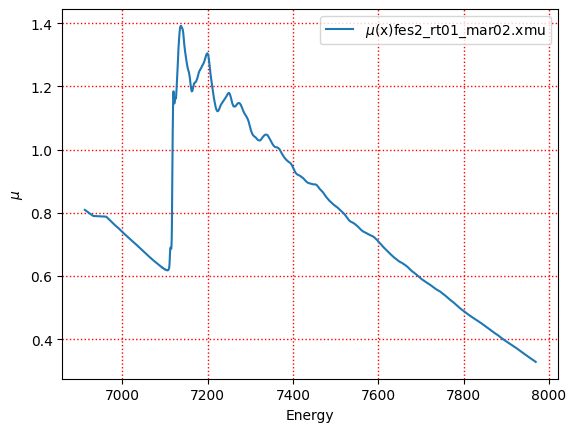

In [1]:
from larch.io import read_ascii
from pathlib import Path

from larch.symboltable import Group

# reproduction needs to record these variables as "external inputs" to the code
# Neither MLProvLab or ReproduceMe consider these

data_labels = "energy mu i0"

file_names = ['fes2_rt01_mar02.xmu']

groups_list=[]

# read ascii files
# labels tell the reader how to name the resulting columns
# eneregy and mu are the most used labels

# if merge read in group and then merge
for a_file in file_names:
    a_group = read_ascii(a_file, labels = data_labels)
    groups_list.append(a_group)

# merge files
fe_xas = groups_list

# the following show the contents of each
for fe_xas in groups_list:
    print("path:\t\t", fe_xas.path)
    print("filename:\t", fe_xas.filename)
    print(fe_xas.header)
    print(fe_xas.data)
    print(fe_xas.attrs)
    print(fe_xas.array_labels)
    print('energy:', fe_xas.energy)
    print('i0:',fe_xas.i0)
    print('xmu:',fe_xas.mu)


## Calculate and plot $\mu$
#Knowing the elements of the input data set it is possible to start manipulating and visualising the XAFS data. 

# In this case $\mu$ is provided, so there is no need to calculate it, just rename it as mu (required by Larch for processing) and plot it agains the energy.


from numpy import log
from larch.utils import group2dict, dict2group

# Calculate mu 
def get_mu(xafs_group):
    # calculate mu
    mu_e = xafs_group.mu
    # get a dictionary from te group
    xafs_dict = group2dict(xafs_group)
    # add mu to the dictionary
    xafs_dict['mu'] = mu_e
    xafs_group = dict2group(xafs_dict)
    return xafs_group

for fe_xas in groups_list:
    fe_xas = get_mu(fe_xas)

    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.plot(fe_xas.energy, fe_xas.mu, label='$\mu$(x)' + fe_xas.filename )
    plt.xlabel('Energy')
    plt.ylabel('$\mu$')
    plt.legend() # include the leyend in the plot
    plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid


    

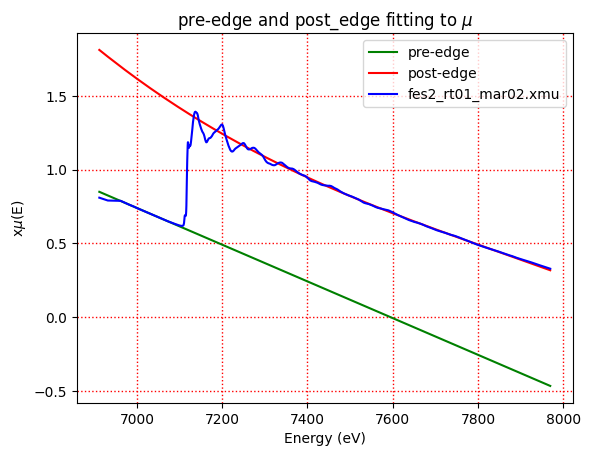

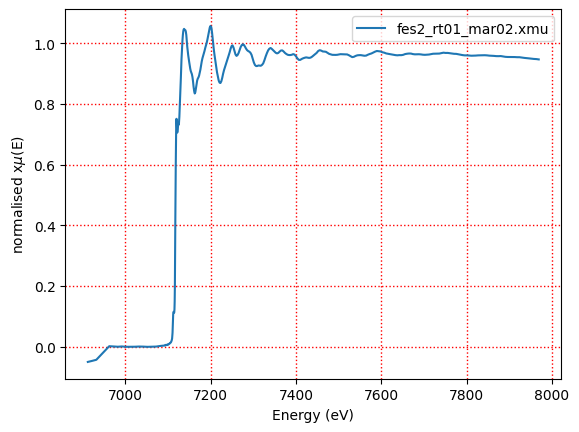

In [2]:
# https://vimeo.com/340207346 25:00
from larch.xafs import pre_edge
#calculate pre-edge and post edge and add them to group
# as with the basic workflow we want to avoid the data below E0 - 117.00

groups_list = groups_list

for fe_xas in groups_list:
    pre_edge(fe_xas, group=fe_xas, pre1=-150, pre2=-30)
    pre_edge(fe_xas, group=fe_xas, pre1=-117, pre2=-30, norm1=150, norm2=750, nnorm = 3)
    #pre_edge(fe_xas, group=fe_xas)
    plt.plot(fe_xas.energy, fe_xas.pre_edge, 'g', label='pre-edge') # plot pre-edge in green
    plt.plot(fe_xas.energy, fe_xas.post_edge, 'r', label='post-edge')# plot post-edge in green
    plt.plot(fe_xas.energy, fe_xas.mu, 'b', label=fe_xas.filename) # plot mu in blue
    plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
    plt.xlabel('Energy (eV)') # label y graph
    plt.ylabel('x$\mu$(E)') # label y axis
    plt.title("pre-edge and post_edge fitting to $\mu$")
    plt.legend() # show legend
#print(vars(fe_xas))
    plt.show()
# https://vimeo.com/340207346 27:00
for fe_xas in groups_list:
    plt.plot(fe_xas.energy, fe_xas.flat, label=fe_xas.filename) # plot flattened and normalised energy
    plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
    plt.xlabel('Energy (eV)') # label y graph
    plt.ylabel(r'normalised x$\mu$(E)') # label y axis
    plt.legend() # show legend
    plt.show()

In [3]:
# import the larch.io libraries for managing athena files
from larch.io import create_athena, read_athena, extract_athenagroup

# save as an athena project

project_name = 'fes2_larch3.prj'
fe_project = create_athena(project_name)
for fe_xas in groups_list:
    fe_project.add_group(fe_xas)
fe_project.save()
vars(fe_project)


{'_larch': None,
 'groups': OrderedDict([('fes2_rt01_mar02_xmu', <Group 0x2b9a8a8b4f0>),
              ('gqksw', <Group ascii_file fes2_rt01_mar02.xmu>)]),
 'header': '# Athena project file -- Demeter version 0.9.24\n# This file created at 2024-06-04T14:08:22\n# Using Larch version 0.9.71, Python 3.9.2rc1 on Windows-10-10.0.22621-SP0\n',
 'journal': '',
 'filename': 'fes2_larch3.prj',
 'group_names': ['fes2_rt01_mar02_xmu']}

# XAS Workflow Task 2

This notebook contains the second task of the XAS processing workflow. 

The break up of the task consist of the following steps 

|Task                            | Input                                         | Output
|-------------                   |-------------                                  |-----  
| Curve fitting||
| 1. Import data                |File: FeS2_larch.prj                              |
| 2. Import Crystal data        |File: FeS2.inp                                 |
| 3. Calculate Paths(Atoms+FEFF)||
| 4. Set path parameters        | Parameters:                                   |
|                                 |    amp  = 1                                   |
|                                 |    enot = 0                                   |
|                                 |    delr = 0                                   |
|                                 |    ss   = 0.003                               |
| 5. Select paths                 |                                               |
| 6. Run Fit                    |                                               |
| 7. Save project               ||
| 8. Verify fit results         ||
| 8.1 If not OK revise parameners and refit (go to 2.4)||
| 8.2 If OK Save project and outputs|                                           |File: FeS2_01.fpj

For more details about larch, see https://xraypy.github.io/xraylarch/xafs/
##  Setup
The setup requires specifying the libraries containing the functions to be used and defining the inputs to use
### Libraries
The first step requires importing the required libraries to perform the workflow tasks
- Manage Athena Files
- Run Atoms and FEFF
- Fit preparation and execution
## Inputs
The second step requires defining the input data to be used. in this case the athena and cif files to be used. The variables can be changed to process different datasets.

In [4]:
# Library with the functions that handle athena files
import lib.manage_athena as athenamgr  

# Library with the functions that execute 
# Atoms and FEFF to generate scattering paths
import lib.atoms_feff as feff_runner     

# Set parameters          
# library containign functions tho manage fit, at read, write 
# GDS parameters, and scattering paths. 
import lib.manage_fit as fit_manager  

from larch import Interpreter

session = Interpreter()

# Additional setup
# direct plotting to the results after running the cells
%matplotlib inline

# variables that can be changed to process different datasets
# define the name of the input file
athena_file = project_name

# provide the input files as a list so more than one 
# crystal file can be used in fitting
crystal_files = ["FeS2.inp"]# ["..\\cif_files\\C12O12Rh4.cif"]## or ["FeS2.inp","FeS.inp"]

show_graph = True # False to prevent showing graphs

# GSD parameters and scattering paths are saved to csv files.
# provide the name of the gds file
gds_file = 'FeS2_gds.csv'
spl_file = 'FeS2_sp.csv'
# variables for fit
fit_vars = {}
fit_vars['fitspace']='r'
fit_vars['kmin']=3 
fit_vars['kmax']=14
fit_vars['kw']=2 
fit_vars['dk']=1
fit_vars['window']='hanning'
fit_vars['rmin']=1.4
fit_vars['rmax']=3.0

No conda env active, defaulting to base


In [5]:
# read the input file 
athena_prj = athenamgr.read_project(athena_file)

athena_groups = athenamgr.get_groups(athena_prj)

group_names = []
for a_group in athena_groups:
    group_names.append(a_group.label)
    
group_names

# recalculate norm, background removal and fourier transform 
# with defaults
data_group = athenamgr.calc_with_defaults(athena_groups[0])

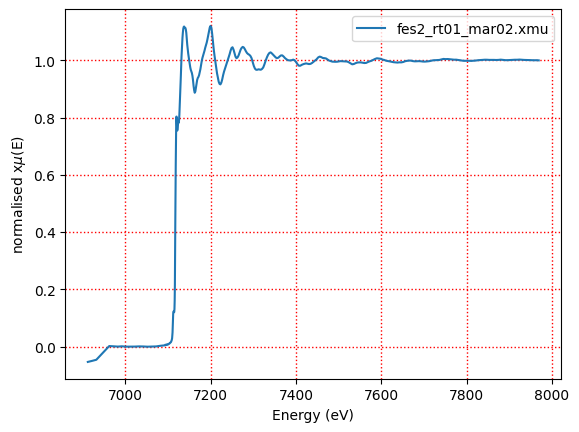

In [6]:
# https://vimeo.com/340207346 27:00
for fe_xas in athena_groups:
    plt.plot(fe_xas.energy, fe_xas.flat, label=fe_xas.filename) # plot flattened and normalised energy
    plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
    plt.xlabel('Energy (eV)') # label y graph
    plt.ylabel(r'normalised x$\mu$(E)') # label y axis
    plt.legend() # show legend


## Atoms and FEFF 

Larch does not include a means for running atoms. Atoms is needed to get input for feff and calculate paths. Currently, the fastest option is to run Artemis to obtain the input (.inp) file for feff from a crystal file ('.cif' or '.inp')

The code below shows how subprocess can be used to call perl, execute a small perl script that runs Artemis Atoms, and saves the output file ('inp') in a new directory.

The file can then be used to run FEFF from Larch to calculate scattering paths.

In [7]:
import importlib
importlib.reload(feff_runner)

# run feff and get a list of feff dirs
feff_dirs = feff_runner.run_feff(crystal_files)

Processing: FeS2.inp
check if need to build: FeS2_feff
copying: FeS2.inp  to  FeS2_feff\FeS2_feff.inp
 : ======== running Feff module C:\Users\scman1\AppData\Local\Programs\Python\Python39\lib\site-packages\larch\bin\win64\feff6l.exe ========
 : Feff 6L.02
 : name:     Iron sulfide (pyrite)
 : formula:  FeS_2
 : refer1:   Elliot (1960) J.Chem. Phys. 33(3), 903.
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts for unique potential    2
 : Preparing plane wave scattering amplitudes...
 : nncrit in prcrit      

## Set Parameters
The code for managing the parameters group (GDS in Artemis) is stored in lib/manage_gds.py. 

The following two cells show how the functions of manage_gds.py are used to read GDS parameters from a file, display the parameters and save them after they have been modified

The parameter values are the same used in [Bruce Ravel's example](https://github.com/bruceravel/demeter/tree/master/examples/recipes/FeS2).

In [8]:
# read save parameters from input gds file
gds = fit_manager.read_gds(gds_file, session)
# show gsd group parameters in a spreadsheet
this_sheet = fit_manager.show_gds(gds)
# save gsd group parameters in a csv file
fit_manager.save_gds(gds, gds_file)

Sheet(cells=(Cell(column_start=0, row_end=18, row_start=0, squeeze_column=False, squeeze_row=False, value=[['i…

In [9]:
#read the gds data from the grid and save it to the csv file
gds = fit_manager.spreadsheet_to_gds(this_sheet, session)
# save gsd group parameters in a csv file
fit_manager.save_gds(gds, gds_file)

### 1 Show all FEFF paths 

To select a path change the value of the select column to 1 in the table displayed after running the cell below.


In [10]:
# read saved selected paths from input file
selected_paths = fit_manager.read_selected_paths_list(spl_file, session)

path_sheet = fit_manager.show_feff_paths(crystal_files,selected_paths)
display(path_sheet)

Sheet(cells=(Cell(column_end=7, column_start=0, row_end=48, row_start=0, squeeze_column=False, squeeze_row=Fal…

### 2 Assing parameters to paths

To define the parameters enter values like those presented in the table below into the spreadsheet that appears after running the code in the following cell. The values should correspond to those defined as GDS parameters previously.

|file                  |label | s02 |e0   |sigma2 |deltar      |
|----------------------|------|-----|-----|-------|------------|
|FeS2_feff/feff0001.dat|S1    |amp  |enot |ss     |alpha\*reff |
|FeS2_feff/feff0002.dat|S2    |amp  |enot |ss2    |alpha\*reff |
|FeS2_feff/feff0003.dat|S3    |amp  |enot |ss3    |alpha\*reff |
|FeS2_feff/feff0004.dat|Fe    |amp  |enot |ssfe   |alpha\*reff |


**Note:** Labelling is used for reference only using Artemis-FEFF given names. Larch's FEFF does not label paths.

In [11]:
sp_sheet = fit_manager.show_selected_paths(path_sheet, selected_paths)

Sheet(cells=(Cell(column_end=5, column_start=0, row_end=4, row_start=0, squeeze_column=False, squeeze_row=Fals…

In [12]:
#selected_paths = fit_manager.build_selected_paths_list(sp_sheet, session)
#fit_manager.save_selected_paths_list(sp_sheet, spl_file)
selected_paths = fit_manager.read_selected_paths_list(spl_file, session)

## Run Fit

XAS fitting is performed in three steps:
1. Create a Transform group to hold the set of Fourier transform parameters, fitting ranges, and space in which the data and sum of paths are to be compared (R space)
2. Create a Dataset group,consistaining of the three components required for fitting(data, paths, and transform group)
3. FEFFIT is run with the list of parameters (gds) for the fit, and the dataset or list of datasets groups.


In [13]:
# run fit
trans, dset, out = fit_manager.run_fit(data_group, gds, selected_paths, fit_vars, session)

## Review fit results
The results of the fit are stored in the dataset. These can be plotted and printed as follows.

- The first view is the overlaped $\chi(k)$ and $\chi(R)$ plots (similar to Demeter's Rmr plot)
- The second view presents separate $\chi(k)$ and $\chi(R)$ plots 

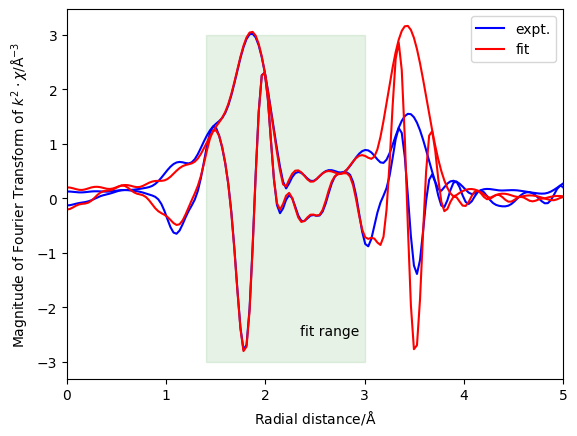

In [14]:
rmr_p = fit_manager.plot_rmr(dset,fit_vars['rmin'],fit_vars['rmax'])
rmr_p.show()

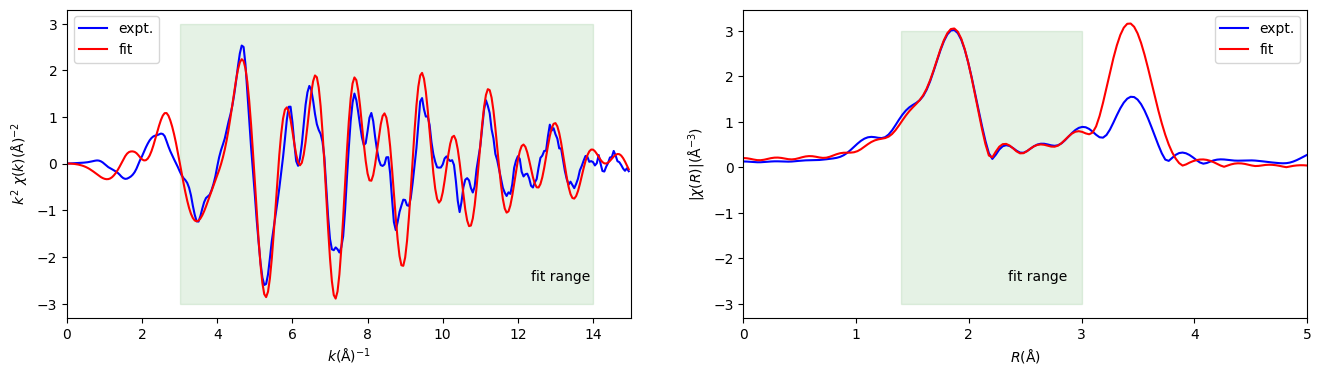

In [15]:
chikr_p = fit_manager.plot_chikr(dset,fit_vars['rmin'],fit_vars['rmax'],fit_vars['kmin'],fit_vars['kmax'])
chikr_p.show()

In [16]:
fit_report = fit_manager.get_fit_report(out, session)

print(fit_report)

#save the fit report to a text file
fit_manager.save_fit_report(out, "fes2_fit_rep.txt", session)

=================== FEFFIT RESULTS ====================
[[Statistics]]
   nvarys, npts       =  8, 104
   n_independent      =  12.205
   chi_square         =  175.307287
   reduced chi_square =  41.6950777
   r-factor           =  0.00138607
   Akaike info crit   =  48.5217792
   Bayesian info crit =  52.5362224
 
[[Data]]
   fit space          = 'r'
   r-range            = 1.400, 3.000
   k-range            = 3.000, 14.000
   k window, dk       = 'hanning', 1.000
   paths used in fit  = ['FeS2_feff/feff0001.dat', 'FeS2_feff/feff0002.dat', 'FeS2_feff/feff0003.dat', 'FeS2_feff/feff0004.dat']
   k-weight           = 2
   epsilon_k          = Array(mean=5.01912e-4, std=4.60149e-4)
   epsilon_r          = 0.01038113
   n_independent      = 12.205
 
[[Variables]]
   alpha          =  5.32353e-5 +/-unknown   (init=  0.00000000)
   amp            =  0.73628552 +/-unknown   (init=  1.00000000)
   delr           =  0.00000000 +/-unknown   (init=  0.00000000)
   enot           =  2.68381266 +/-

In [17]:
vars(session)

{'symtable': <Group _main>,
 'input': <larch.inputText.InputText at 0x2b9ad0c3700>,
 'writer': <larch.larchlib.StdWriter at 0x2b9ad0c34f0>,
 '_interrupt': None,
 'error': [],
 'expr': None,
 'retval': None,
 '_calldepth': 0,
 'func': None,
 'fname': '<stdin>',
 'lineno': 0,
 'on_try': <bound method Interpreter.on_tryexcept of <larch.interpreter.Interpreter object at 0x000002B9AAC321F0>>,
 'on_tryfinally': <bound method Interpreter.on_tryexcept of <larch.interpreter.Interpreter object at 0x000002B9AAC321F0>>,
 'node_handlers': {'arg': <bound method Interpreter.on_arg of <larch.interpreter.Interpreter object at 0x000002B9AAC321F0>>,
  'assert': <bound method Interpreter.on_assert of <larch.interpreter.Interpreter object at 0x000002B9AAC321F0>>,
  'assign': <bound method Interpreter.on_assign of <larch.interpreter.Interpreter object at 0x000002B9AAC321F0>>,
  'attribute': <bound method Interpreter.on_attribute of <larch.interpreter.Interpreter object at 0x000002B9AAC321F0>>,
  'augassign'

In [18]:
feff_dirs

['FeS2_feff']